# Smoothing Spline Regression

## Introduction 

Let $y = (y_1,\ldots,y_n)$ be a vector of $n$ noisy observation of a univariate, real-valued function $f$, i.e.,
$$ y_i = f(t_i) + e_i, \qquad i =1,\ldots,n,$$
where $f$ is an unknown function of interest, $e = (e_1,\ldots,e_n)$ represents measurement noise, and the sequence $t_1,\ldots,t_n$ is increasing and its elements are contained in some interval $[a,b]$. The smoothing spline regression problem seeks a function $f$ that minimizes the functional
$$J(f)=\frac{1}{n}\sum_{i=1}^n (y_i - f(t_i))^2 + \lambda \int_a^b |f^{(p)}(t)|^2 \, dt,$$
defined over the space of functions with absolutely continuous $(p-1)$th derivative and square integrable $p$th derivative over $[a,b]$. The first term (the summation) may be viewed as a *data fidelity* term that penalizes deviations from the observations, and second term (the integral) can be viewed as a *roughness penalty* that introduces some degree of smoothness. Schoenberg (1964) showed that the solution is a so-called *natural spline* of order $2p$, i.e., a piecewise polynomial function with polynomial pieces of degree at most $2p-1$. Such splines can be parameterized with exactly $n$ degrees of freedom. Reinsch (1967) proposed an algorithm for the special case where $p=2$, corresponding to a natural cubic spline. This algorithm was later generalized to other values of $p$ (Reinsch 1971).


An alternative approach to solving the smoothing spline regression problem is to equip the space of functions that have an absolutely continuous $(p-1)$th derivative and square integrable $p$th derivative with a suitable inner product (Wahba 1990). This approach yields a convex quadratic optimization problem of the form
$$\mbox{minimize} \ \ \frac{1}{n} \|y - \Sigma c - Fd \|_2^2 + \lambda\, c^T\Sigma c$$
with variables $c \in \mathbb{R}^n$ and $d \in \mathbb{R}^d$. The matrix $F \in \mathbb{R}^{n \times p}$ is a Vandermonde matrix, and the matrix $\Sigma$ is a positive semidefinite matrix of order $n$ with entries generated by the so-called spline kernel. As shown in (Andersen & Chen 2019), for a specific choice of the aforementioned inner product, $\Sigma$ becomes a rank structured matrix of the form $\Sigma = S(U,V)$
where 
$$S(U,V) = \mathrm{tril}(UV^T) + \mathrm{triu}(VU^T,1), \qquad U,V \in \mathbb{R}^{n \times p}.$$
As a consequence, $\Sigma$ has an implicit representation (a so-called *generator representation*) that only requires $O(np)$ storage and allows us to compute an implicit Cholesky factorization in $O(p^2n)$ floating point operations. 

In the following, we illustrate how to exploit the rank structure of $\Sigma$ in order to solve the above convex quadratic problem in $O(p^2n)$ operations.

## Simulated Data Example

We start by generating $n$ random samples of the form 
$$y_i = f(t_i) + e_i, \qquad i =1,\ldots,n,$$
where we use as $f$ the smooth function
$$f(t) = \cos(2\pi t) + \frac{3}{10} \sin(10 \pi t) + \frac{t}{5}.$$ 
We draw $t_1,\ldots,t_n$ as independent samples from a uniform distribution on the interval $[a,b]$, and the noise $e = (e_1,\ldots,e_n)$ is a vector of independent samples from a zero mean Gaussian distribution with variance $\sigma^2$. 

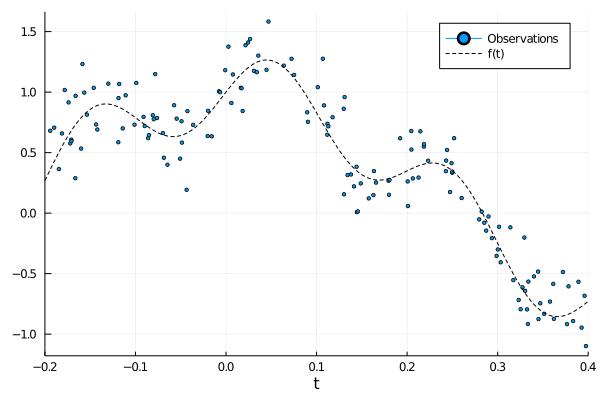

In [1]:
using Plots, LinearAlgebra, Optim, SpecialFunctions, Printf, LaTeXStrings
include("../../src/julia/egrss.jl")

n = 150         # number of samples
σ = 0.2         # noise standard deviation
a,b = -0.2,0.4  # interval [a,b]

t = a .+ sort(rand(n))*(b-a)
f(t) = cos.(2*π*t) .+ 0.3*sin.(10*π*t) .+ 0.2*t 
y = f(t) + σ*randn(n,1)

p1 = plot(t, y, ms=2, lw=0, shape=:circle, label="Observations", xlims=(a,b), xlabel="t") 
plot!(a:0.5/n:b, f(a:0.5/n:b), label="f(t)", ls=:dash, color=:black)

## Solving the Smoothing Spline Regression Problem

It can be shown from the optimality conditions associated with the problem
$$\mbox{minimize} \ \ \frac{1}{n} \|y - \Sigma c - Fd \|_2^2 + \lambda\, c^T\Sigma c$$
that there exists a solution $c,d$ that satisfies the system of equations
$$
\begin{bmatrix}
    \Sigma + n\lambda I & F \\
    F^T & 0 
\end{bmatrix} \begin{bmatrix} c\\d \end{bmatrix}
= \begin{bmatrix} y \\ 0 \end{bmatrix}.
$$
We will exploit the rank structure inherent in $\Sigma$ when solving this system. Specifically, we will use the following routines from `egrss.jl` in order to:

- compute a generator representation $S(U,V)$ of $\Sigma$ (`egrss.generators()`);
- compute an implicit Cholesky factorization $S(U,V) + D = LL^T$ where $D$ is diagonal (`egrss.potrf()`);
- solve systems of the form $Lx=b$ and $L'x=b$ (`egrss.trsv()`). 

The matrix $\Sigma$ can be expressed as $\Sigma = \zeta K$ where $\zeta = (b-a)^{2p-1}$ and $K$ is the kernel matrix with entries generated by the spline kernel. Specifically, the $(i,j)$ entry of $K$ is $K_{ij} = \kappa_p(t_i,t_j)$ where 
$$\kappa_p(s,t) = 
\begin{cases} 
\sum_{k=1}^{p} (-1)^{k-1} \phi_{p+1-k}(s) \phi_{p+k}(t) & s \geq t \\
\sum_{k=1}^{p} (-1)^{k-1} \phi_{p+1-k}(t) \phi_{p+k}(s) & s < t
\end{cases}$$
and $\phi_k(t) = \frac{t^{k-1}}{(k-1)!}$ for $k=1,\ldots,2p$. The matrix $K$ is a so-called extended generator representable $p$-semiseparable matrix which can be expressed as $K=S(U,V)$, and the generators $U$ and $V$ can be formed in $O(pn)$ operations using the routine `egrss.generators()`.

Now, if we define $M_{\lambda} = K + n\lambda/\zeta I$ and let $M_{\lambda} = LL^T$ be the Cholesky factorization of $M_{\lambda}$, the solution $c,d$ can be found by solving the equations
$$Rd = Q_1^TL^{-1}y, \qquad \zeta L^Tc = Q_2Q_2^T L^{-1}y,$$
where $R$ is an upper triangular $p\times p$ matrix obtained through a QR decomposition of $B = L^{-1}F$, i.e.,
$$L^{-1}F = \begin{bmatrix}Q_1 & Q_2\end{bmatrix} \begin{bmatrix}R\\0\end{bmatrix}.$$
The lower triangular matrix $L$ is itself a rank structured matrix which can be expressed as
$$L=\mathrm{tril}(UW^T,-1) + \mathrm{diag}(z)$$
where $U, W \in \mathbb{R}^{n \times p}$ and $z \in \mathbb{R}_{++}^n$. 
The matrix $W$ and the vector $z$ can be computed using `egrss.potrf()`, 
and we can solve systems of the form $Lx=b$ and $L'x=b$ in $O(pn)$ floating point operations using `egrss.trsv()`.

Remark: the functions defined in `egrss.jl` generate and operate on $U^T$, $V^T$, and $W^T$ to ensure cache efficient access to the rows of $U$, $V$, and $W$. Moreover, the generator matrix $U$ is chosen such that $F = U$.

The following function computes and returns $\zeta c$ and $d$ given $U$, $W$, $z$, and $y$.

In [2]:
function smoothing_spline_reg(Ut,Wt,z,y; obj=Nothing)
    p,n = size(Ut)
    B = zeros(n,p)
    for k = 1:p
        B[:,k] = egrss.trsv(Ut,Wt,z,Ut[k,:]','N')   # Compute B[:,k] = L\U[:,k]
    end
    F = qr(B)
    c̃ = egrss.trsv(Ut,Wt,z,y,'N')                   # Compute c̃ = L\y
    c̃ = F.Q'*c̃
    d = F.R\c̃[1:p]
    c̃[1:p] .= 0.0
    c̃ = egrss.trsv(Ut,Wt,z,F.Q*c̃,'T')               # Compute c̃ := L'\(Q*c̃)

    if obj===Nothing
        return c̃,d
    elseif obj=="gml"
        log_gml = log(dot(y,c̃)) + 2.0/(n-p)*(sum(log.(z)) + sum(log.(abs.(diag(F.R)))))
        return c̃,d,log_gml
    else
        error("Unknown objective.")
    end
end;

## Varying the Roughness Penalty

We now solve the smoothing spline regression problem for three different values of $\lambda$ and plot the resulting splines.

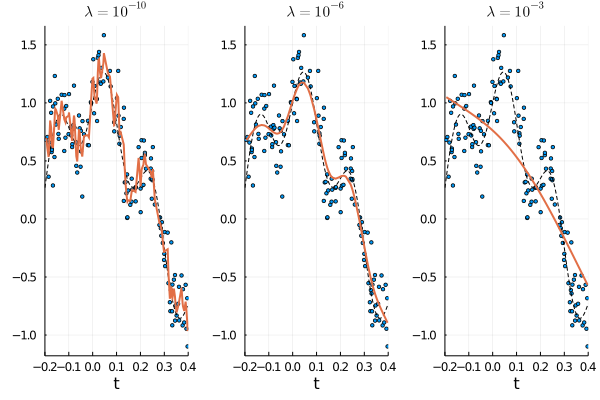

In [3]:
p = 2
ζ = (b-a)^(2*p-1)

# Compute spline kernel generator arrays
Ut,Vt = egrss.generators((t.-a)/(b-a),p)

# Solve the smoothing spline regression problem for three different values of λ
λ = 1e-10
Wt,z = egrss.potrf(Ut,Vt,n*λ/ζ)
c̃,d = smoothing_spline_reg(Ut,Wt,z,y)
p1 = plot(t, y, ms=2, lw=0, shape=:circle, xlims=(a,b), xlabel="t", legend=false) 
plot!(a:0.5/n:b, f(a:0.5/n:b), ls=:dash, color=:black)
plot!(t, y-n*λ/ζ*c̃, color=2, lw=2, title=L"\lambda = 10^{-10}", titlefontsize=10)

λ = 1e-6
Wt,z = egrss.potrf(Ut,Vt,n*λ/ζ)
c̃,d = smoothing_spline_reg(Ut,Wt,z,y)
p2 = plot(t, y, ms=2, lw=0, shape=:circle, xlims=(a,b), xlabel="t", legend=false) 
plot!(a:0.5/n:b, f(a:0.5/n:b), ls=:dash, color=:black)
plot!(t, y-n*λ/ζ*c̃, color=2, lw=2, title=L"\lambda = 10^{-6}", titlefontsize=10)

λ = 1e-3
Wt,z = egrss.potrf(Ut,Vt,n*λ/ζ)
c̃,d = smoothing_spline_reg(Ut,Wt,z,y)
p3 = plot(t, y, ms=2, lw=0, shape=:circle, xlims=(a,b), xlabel="t", legend=false) 
plot!(a:0.5/n:b, f(a:0.5/n:b), ls=:dash, color=:black)
plot!(t, y-n*λ/ζ*c̃, color=2, lw=2, title=L"\lambda = 10^{-3}", titlefontsize=10)

plot(p1, p2, p3, layout = @layout [a b c])

## Estimating the Hyperparameters

The problem of estimating $\sigma$ and $\lambda$ may be cast as a so-called *generalized maximum likelihood* (GML) estimation problem which is equivalent to minimizing the following objective function
$$h(\lambda) = \log(\zeta c^Ty) +\frac{2}{n-p} \log\det(L) + \frac{2}{n-p} \log\det(R) + \mathrm{const.}$$
After obtaining an estimate of $\lambda$ by (locally) minimizing $h(\lambda)$, we may compute a GML estimate of $\hat \sigma$ as
$$\hat \sigma^2 = n \hat\lambda \frac{c^Ty}{n-p}.$$

We will now use `Optim.jl` to find a local minimizer of $h$ by means of golden section search. To this end, we will make a change of variables $\lambda = 10^\nu$ and use $\nu$ as the optimization variable.

In [4]:
function log_gml(ν)
    Wt,z  = egrss.potrf(Ut,Vt,n*(10^ν)/ζ)
    c̃,d,obj = smoothing_spline_reg(Ut,Wt,z,y,obj="gml")        
    return obj
end

# Estimate λ̂ based on the GML criterion using golden section search
res = optimize(log_gml, -10, 0, GoldenSection(), rel_tol=1e-3)
display(res)
λ̂ = 10^(res.minimizer)

# Compute c, d, and σ̂
Wt,ct  = egrss.potrf(Ut,Vt,n*λ̂/ζ)
c̃,d = smoothing_spline_reg(Ut,Wt,ct,y);
σ̂ = sqrt(n*λ̂/ζ*dot(c̃,y)/(n-p))

@printf "%s\n" "-"^64
@printf "Estimated lambda    : %.2e\n" λ̂
@printf "Estimated noise std.: %.2e\n" σ̂

Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [-10.000000, 0.000000]
 * Minimizer: -6.981539e+00
 * Minimum: 2.048275e+00
 * Iterations: 13
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-03*|x|+2.2e-16): true
 * Objective Function Calls: 14

----------------------------------------------------------------
Estimated lambda    : 1.04e-07
Estimated noise std.: 1.96e-01


## Bayesian Credible Interval

To construct Bayesian credible intervals, we need to compute the diagonal elements of the matrix $H(\hat \lambda)$ which is defined as
$$H(\hat\lambda) = I - n\hat\lambda/\zeta L^{-T}Q_2Q_2^TL^{-1}$$
where $L$ is the Cholesky factor of $M_{\hat\lambda} = K+n\hat\lambda/\zeta I$, and $Q_2$ a matrix whose columns form an orthonormal basis for the nullspace of $F$ which may be obtained from a QR decomposition of $B = L^{-1}F$.
The standard deviation associated with the posterior of $\hat y_i$ is then given by
$$\hat \sigma_{i}^2 = \hat \sigma^2 e_i^T H(\hat \lambda) e_i.$$


In [5]:
dH = zeros(n)
B = zeros(n,p)
for k = 1:p
    B[:,k] = egrss.trsv(Ut,Wt,ct,Ut[k,:]','N')
end
F = qr(B)
for k in 1:n
    ek = zeros(n)
    ek[k] = 1.0
    v = F.Q'*egrss.trsv(Ut,Wt,ct,ek)
    dH[k] = 1.0-n*λ̂/ζ*norm(v[p+1:end])^2
end

## Visualizing the solution

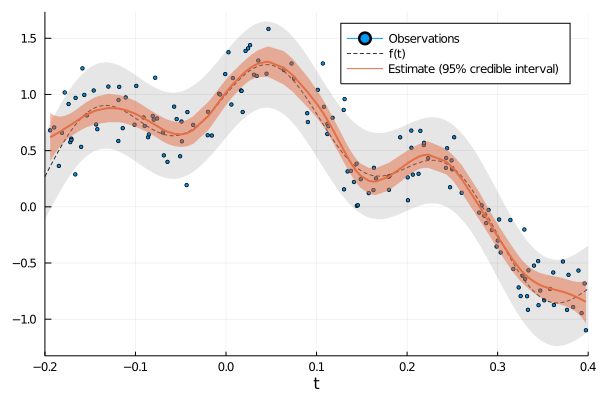

In [6]:
# Compute number of standard deviations δ that corresponds to credible interval 1-α
α = 0.05
δ = sqrt(2)*erfinv(1-α)

p2 = plot(t, y, ms=2, lw=0, shape=:circle, label="Observations", xlims=(a,b), xlabel="t") 
plot!(a:0.5/n:b,f(a:0.5/n:b),color=:black, ls=:dash, label="f(t)", ribbon=δ*σ̂, alpha=0.8, fillalpha=0.1)
plot!(t,y-n*λ̂/ζ*c̃,color=2, label=@sprintf("Estimate (%.0f%% credible interval)",100*(1-α)), lw=2, ribbon=δ*σ̂*sqrt.(dH), fillalpha=0.5)

The dashed curve is the ground truth (i.e., $f$), the shaded gray area corresponds to $f(t) \pm \delta \, \sigma$, the red curve is the estimated function $\hat f(t)$, and the shaded red area marks the corresponding $1-\alpha$ credible interval ($\hat f(t_i) \pm \delta \, \hat \sigma_i$).

# References

1. Andersen, M. S., and Chen, T., 2020. "Smoothing Splines and Rank Structured Matrices: Revisiting the Spline Kernel." *SIAM Journal on Matrix Analysis and Applications*, 41(2) 389-412; DOI: [10.1137/19M1267349](https://doi.org/10.1137/19M1267349)
2. Reinsch, C. H., 1967. "Smoothing by Spline Functions." *Numerische Matematik*, 10 177–183; DOI: [10.1007/BF02162161](https://doi.org/10.1007/BF02162161)
3. Reinsch, C. H., 1971. "Smoothing bySplineFunctions. II." *Numerische Matematik*, 16 451–454; DOI: [10.1007/BF02169154](https://doi.org/10.1007/BF02169154)
4. Schoenberg, I. J., 1964. "Spline Functions and the Problem of Graduation." *Proceedings of the National Academy of Sciences*, 52(4) 947–950; DOI: [10.1073/pnas.52.4.947](https://doi.org/10.1073/pnas.52.4.947)
5. Wahba, G., 1990. "Spline Models for Observational Data." *SIAM*; DOI: [10.1137/1.9781611970128](https://doi.org/10.1137/1.9781611970128).